# Image Preprocessing

In [1]:
! pip -qq install geopandas
! pip -qq install supermercado
! pip -qq install rio-cogeo
! pip -qq install rio-tiler

     |████████████████████████████████| 972kB 7.8MB/s 
     |████████████████████████████████| 10.9MB 14.1MB/s 
     |████████████████████████████████| 14.7MB 255kB/s 
     |████████████████████████████████| 18.2MB 249kB/s 
     |████████████████████████████████| 122kB 7.0MB/s 


In [2]:
from google.colab import drive
import os
from pathlib import Path
import numpy as np
import pandas as pd, geopandas as gpd
import PIL
import rasterio, shapely, rio_tiler, rio_cogeo
from rio_tiler import main as rt_main
import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
dir_mydrive = Path('/content/drive/My Drive')
dir_project = dir_mydrive/'Official Folder for Engie project'
dir_data = dir_project/'Data'

## Read image

In [5]:
path_jurongtif = dir_data/'Satellite Imagery/Jurong Island/012811348010_01_P001_PSH/19DEC27033226-S2AS-012811348010_01_P001.TIF'

In [6]:
! rio cogeo validate '{str(path_jurongtif)}'

The following warnings were found:
- The file is greater than 512xH or 512xW, it is recommended to include internal overviews

The following errors were found:
- The file is greater than 512xH or 512xW, but is not tiled
- The offset of the main IFD should be 8 for ClassicTIFF or 16 for BigTIFF. It is 617441108 instead
- The offset of the first block of the image should be after its IFD
/content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Jurong Island/012811348010_01_P001_PSH/19DEC27033226-S2AS-012811348010_01_P001.TIF is NOT a valid cloud optimized GeoTIFF


In [ ]:
! sudo apt install imagemagick

In [68]:
! file '{str(path_jurongtif)}' |  cat

/content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Jurong Island/012811348010_01_P001_PSH/19DEC27033226-S2AS-012811348010_01_P001.TIF: TIFF image data, little-endian


In [88]:
! rio cogeo create '{str(path_jurongtif)}' jurong_jpeg.tif -b 1,2,3 --add-mask --cog-profile jpeg
# ! ! rio cogeo create '{str(path_jurongtif)}' jurong_jpeg.tif -b 1,2,3 --add-mask --cog-profile lzw
# ! rio cogeo create '{str(path_jurongtif)}' jurong_jpeg.tif -b 1,2,3 --add-mask --cog-profile jpeg --overview-resampling lanczos
# ! rio cogeo create '{str(path_jurongtif)}' jurong_jpeg.tif -b 1,2,3 --add-mask --cog-profile jpeg --web-optimized --resampling cubic

Reading input: /content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Jurong Island/012811348010_01_P001_PSH/19DEC27033226-S2AS-012811348010_01_P001.TIF
  [####################################]  100%          
Adding overviews...
Updating dataset tags...
Writing output to: /content/jurong_jpeg.tif


In [89]:
! rio cogeo validate jurong_jpeg.tif

/content/jurong_jpeg.tif is a valid cloud optimized GeoTIFF


In [90]:
path_cog = Path('jurong_jpeg.tif')

In [91]:
rasterio.open(path_cog).meta

{'count': 3,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 11129,
 'nodata': None,
 'transform': Affine(6.29999999504031e-06, 0.0, 103.65316290000001,
       0.0, -6.29999999504031e-06, 1.2927222000000003),
 'width': 13813}

## Manually draw polygons


This step could be used to define beforehand which part of the satellite image will make up the training set and which part the test set.

The Jurong Island image is imported into QGIS, and two polygons are drawn to mark out two non-overlapping areas.  Here, one is labeled 'train' and the other 'valid'.  Note these are just for illustrative purposes.  Actual areas for training and validation/testing are still need to be decided.

The drawn polygons are exported as a geojson file.



<a href="https://imgur.com/XcCD1ee"><img width="500" src="https://i.imgur.com/XcCD1ee.png" title="source: imgur.com" /></a>

## Load geojson file with `geopandas`.

Download the geojson file exported from QGIS above.

In [11]:
# ! wget -O jurong_image_regions.geojson https://drive.google.com/uc?export=download&id=1Oj066p1IgTH86Kz3Ko85ElNAlDDilthh
# ! wget -O jurong_image_regions.geojson https://www.dropbox.com/s/85y90b7jrceqiou/jurong_image_regions.geojson?dl=0

In [12]:
path_jurong_regions = dir_mydrive/'jurong_image_regions.geojson'

In [13]:
jurong_regions = gpd.read_file(path_jurong_regions)

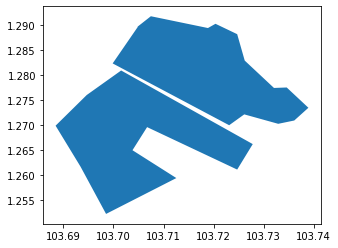

In [14]:
jurong_regions.plot();

In [15]:
jurong_regions

id dataset                                           geometry
0   0   train  MULTIPOLYGON (((103.69343 1.26172, 103.68844 1...
1   1   valid  MULTIPOLYGON (((103.70484 1.28962, 103.70484 1...

## Create tiles over the original satellite image

Save the 'train' and 'valid' polygons into separate geojson files.

In [16]:
for n in ('train', 'valid'):
    (jurong_regions[jurong_regions.dataset == n]
     .geometry
     .to_file(f'jurong_{n}_region.geojson', driver='GeoJSON'))

Run `Supermercado` on each of these geojson files.  It breaks a polygon into tiles.  Note that the size and zoom of the tiles can be adjusted.

The following outputs another set of geojson files, containing these tiles.

In [78]:

zoom_level = 16

In [79]:
! cat jurong_train_region.geojson | supermercado burn {zoom_level} | mercantile shapes | fio collect > jurong_train_z{zoom_level}tiles.geojson
! cat jurong_valid_region.geojson | supermercado burn {zoom_level} | mercantile shapes | fio collect > jurong_valid_z{zoom_level}tiles.geojson

In [80]:
trn_tiles = gpd.read_file(f'jurong_train_z{zoom_level}tiles.geojson')
val_tiles = gpd.read_file(f'jurong_valid_z{zoom_level}tiles.geojson')
trn_tiles['dataset'] = 'train'
val_tiles['dataset'] = 'valid'

In [81]:
tiles = gpd.GeoDataFrame(pd.concat([trn_tiles, val_tiles], ignore_index=True), crs=trn_tiles.crs)
tiles.drop_duplicates(subset=['id'], inplace=True)

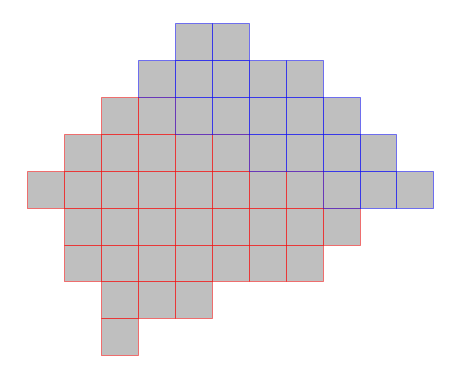

In [82]:
_, ax = plt.subplots(figsize=(8, 8))
tiles[tiles.dataset=='train'].plot(ax=ax, color='grey', edgecolor='red', alpha=.5)
tiles[tiles.dataset=='valid'].plot(ax=ax, color='grey', edgecolor='blue', alpha=.5)
ax.axis('off');

In [83]:
def reformat_xyz(df):
  '''
  Adds a new column for (x, y, z) of a tile.
  '''
  df['xyz'] = df.id.apply(lambda x: x.lstrip('(,)').rstrip('(,)').split(','))
  df['xyz'] = [[int(q) for q in p] for p in df['xyz']]
  return df

In [84]:
tiles = reformat_xyz(tiles)

In [85]:
len(tiles)

53

## Extract the image of a tile

In [86]:
TILE_SIZE = 1024

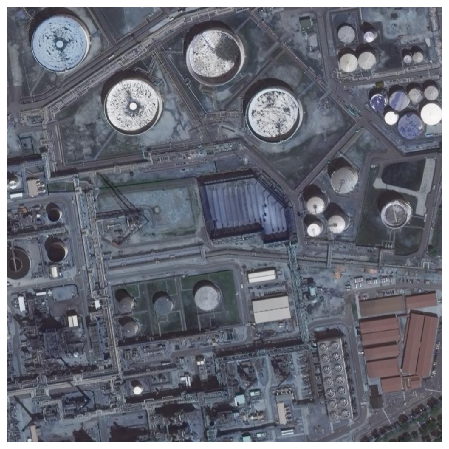

In [93]:
idx = 10
tiles.iloc[idx]['xyz']
tile, mask = rt_main.tile(path_cog, *tiles.iloc[idx].xyz, tilesize=TILE_SIZE)
tile = tile.transpose([1, 2, 0])
_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(tile, interpolation='none')
ax.axis('off');

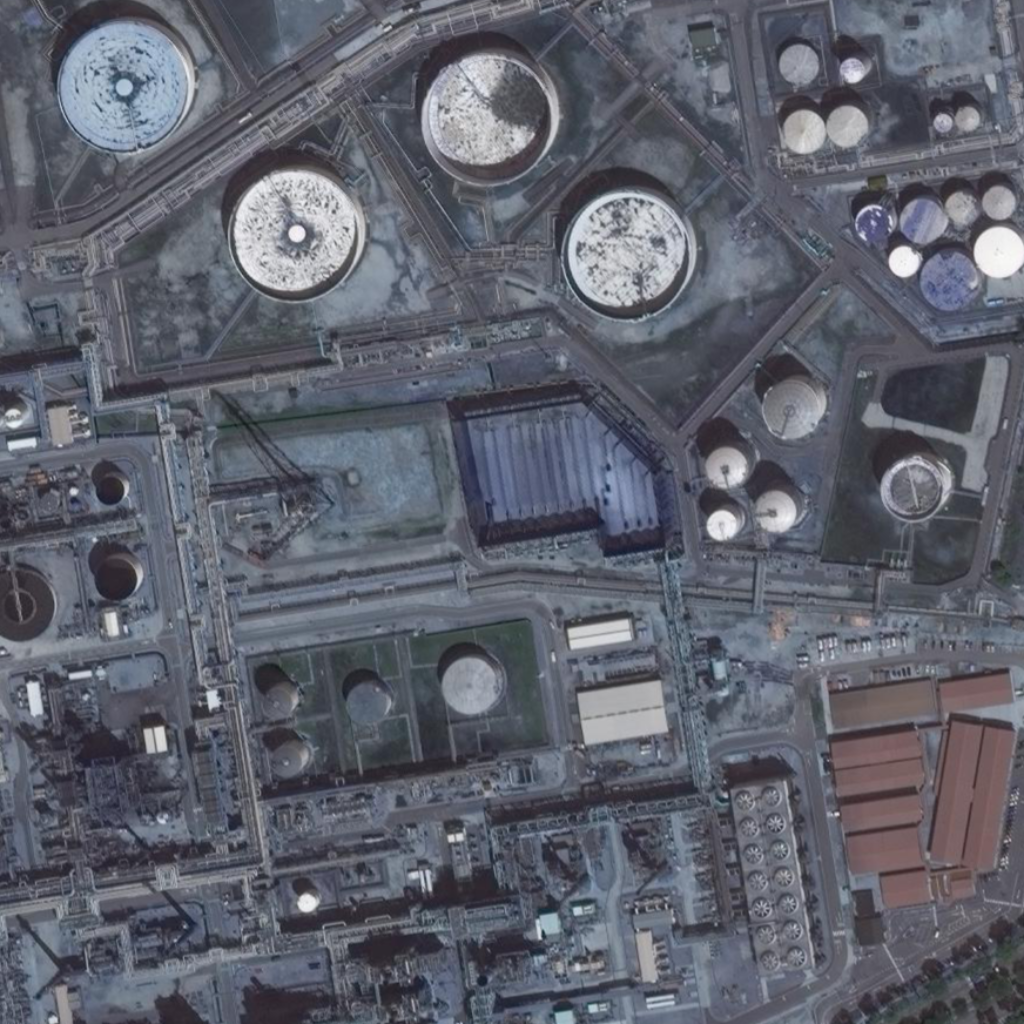

In [94]:
PIL.Image.fromarray(tile)

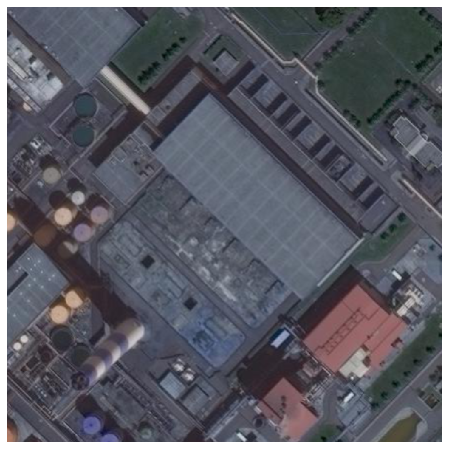

In [ ]:
idx = 146
tiles.iloc[idx]['xyz']
tile, mask = rt_main.tile(path_cog, *tiles.iloc[idx].xyz, tilesize=TILE_SIZE)
tile = tile.transpose([1, 2, 0])
_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(tile, interpolation='none')
ax.axis('off');

In [ ]:
PIL.Image.fromarray(tile).save(dir_mydrive/'test_img_104.jpg')

## Using GDAL

In [50]:
import gdal

In [51]:
dir_jurong_tiles = dir_mydrive/'jurong_tiles'
os.makedirs(dir_jurong_tiles, exist_ok=True);

In [52]:
def convert_to_tile_jpegs(tile_size_x, tile_size_y, source_tif_filename):
    original_path = os.path.abspath(source_tif_filename)
    filename = os.path.basename(original_path)
    path = os.path.dirname(original_path)
    
    out_path = os.path.join(path, f'tiles_{tile_size_x}_{tile_size_y}')
    if os.path.exists(out_path):
        os.rmdir(path)
    os.mkdir(out_path)
    output_filename = 'tile_'
    ds = gdal.Open(os.path.join(path,filename))
    band = ds.GetRasterBand(1)
    xsize = band.XSize
    ysize = band.YSize
 
    for i in range(0, xsize, tile_size_x):
        for j in range(0, ysize, tile_size_y):
            com_string = "gdal_translate -of JPEG -srcwin " + str(i)+ ", " + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + f'\"{os.path.join(path,filename)}\"' + " " + f'\"{os.path.join(out_path, output_filename + str(i) + "_" + str(j) + ".jpeg" )}\"'
            os.system(com_string)

In [ ]:
# convert_to_tile_jpegs(1024, 1024, path_jurongtif)

In [ ]:
path_jurongtif.parent

PosixPath('/content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Jurong Island/012811348010_01_P001_PSH')

In [ ]:
! cat "{dir_tiles/[n for n in os.listdir(dir_tiles) if n.endswith('.xml')][0]}"

<PAMDataset>
  <SRS>GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]</SRS>
  <GeoTransform>  1.0365316290000001e+02,  6.2999999918324524e-06,  0.0000000000000000e+00,  1.2927222000000003e+00,  0.0000000000000000e+00, -6.2999999999826238e-06</GeoTransform>
  <Metadata domain="IMAGE_STRUCTURE">
    <MDI key="COMPRESSION">JPEG</MDI>
    <MDI key="INTERLEAVE">PIXEL</MDI>
    <MDI key="SOURCE_COLOR_SPACE">CMYK</MDI>
  </Metadata>
  <Metadata>
    <MDI key="AREA_OR_POINT">Area</MDI>
    <MDI key="TIFFTAG_COPYRIGHT">(C) COPYRIGHT 2019 DigitalGlobe, Inc., Longmont CO USA 80503</MDI>
    <MDI key="TIFFTAG_DATETIME">2020:07:13 22:45:40</MDI>
    <MDI key="TIFFTAG_IMAGEDESCRIPTION">{
  bandList = 
  [
    2;
    3;
    4;
    5;
  ]
}</MDI>
    <MDI key="TIFFTAG_MAXSAMPLEVALUE">255</MDI>
    <MDI key="TIFFTAG_MINSAMPLEVALUE">0</MDI>
  </Meta

In [ ]:
dir_tiles = Path(os.path.join(path_jurongtif.parent, f'tiles_{1024}_{1024}'))
fns_tiles = os.listdir(dir_tiles)
fns_tiles = [dir_tiles/n for n in fns_tiles if n.endswith('.jpeg')]
fns_tiles[:4]

[PosixPath('/content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Jurong Island/012811348010_01_P001_PSH/tiles_1024_1024/tile_0_0.jpeg'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Jurong Island/012811348010_01_P001_PSH/tiles_1024_1024/tile_0_1024.jpeg'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Jurong Island/012811348010_01_P001_PSH/tiles_1024_1024/tile_0_2048.jpeg'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Jurong Island/012811348010_01_P001_PSH/tiles_1024_1024/tile_0_3072.jpeg')]

In [ ]:
np.array(PIL.Image.open(fns_tiles[80])).shape

(1024, 1024, 4)

In [ ]:
! sudo apt-get install identify

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package identify


In [ ]:
! identify -format '%[colorspace]' '{fns_tiles[50]}'

/bin/bash: identify: command not found


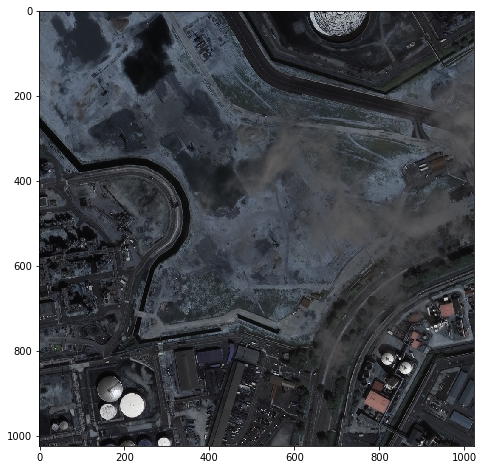

In [ ]:
_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(PIL.Image.open(fns_tiles[90]).convert('RGB'), interpolation='none');

In [ ]:
np.array(PIL.Image.open(dir_data/'tiles'/os.listdir(dir_data/'tiles')[56])).shape

(800, 800, 3)

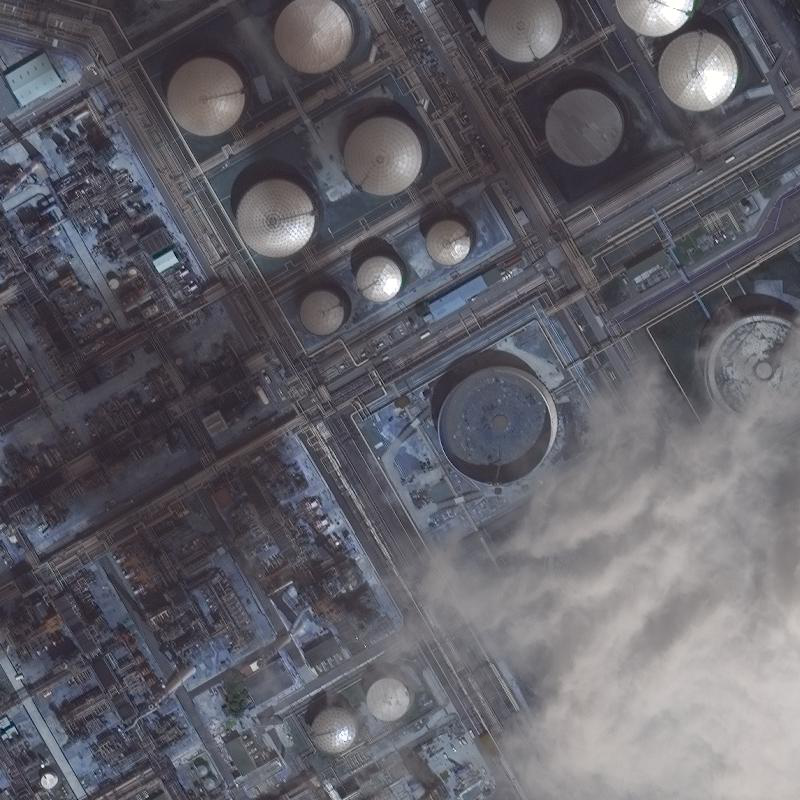

In [ ]:
PIL.Image.open(dir_data/'tiles/jpg_rgb_jurong/jurong_tiles.29.jpeg')

## Reference
[Zanzibar Aerial Mapping by *Dave Luo*](https://github.com/daveluo/zanzibar-aerial-mapping/blob/master/README.md)

[COG Talk — Part 1: What’s new? by *Vicent Sarago*](https://www.gis.usu.edu/~chrisg/python/2009/lectures/ospy_slides4.pdf)

[RIO-COGEO](https://github.com/cogeotiff/rio-cogeo)

[RIO-TILER](https://github.com/cogeotiff/rio-tiler)

[CREATING CUSTOM GEOJSON MAPS FOR HIGHMAPS WITH QGIS](http://www.independent-software.com/creating-custom-geojson-maps-for-highmaps-with-qgis.html)